In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [2]:
# data is organized into 2 columns with first column being a string (text), and second column being an emotion (label)
# data is categorized as sadness (0), joy (1), love (2), anger (3), fear (4), surprise(5).
test_emotions = pd.read_csv('test.csv')
training_emotions = pd.read_csv('training.csv')
emotions = [test_emotions, training_emotions]
emotions_df = pd.concat(emotions)
print(emotions_df)

                                                    text  label
0      im feeling rather rotten so im not very ambiti...      0
1              im updating my blog because i feel shitty      0
2      i never make her separate from me because i do...      0
3      i left with my bouquet of red and yellow tulip...      1
4        i was feeling a little vain when i did this one      0
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[18000 rows x 2 columns]


# Clean and preprocess dataset

In [3]:
# text has already been lowercased, remove numbers, set stopwords, lemmatize and tokenize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

emotions_df = emotions_df.sample(frac=1)

emotions_df = emotions_df.dropna()

def cleaning_and_preprocessing(emot):
    training_emotion = re.sub(r'http\S+|www\S+|@\S+|#\S+|[^A-Za-z0-9\s]', '', emot)
    words = emot.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Apply preprocessing to all of the tweets in the 'text' column
emotions_df['text'] = emotions_df['text'].apply(cleaning_and_preprocessing)

In [4]:
## get sadness, joy, love, anger, fear, from the dataset
emotions_df_sadness = emotions_df.loc[emotions_df['label'] == 0]
emotions_df_joy = emotions_df.loc[emotions_df['label'] == 1]
emotions_df_love = emotions_df.loc[emotions_df['label'] == 2]
emotions_df_anger = emotions_df.loc[emotions_df['label'] == 3]
emotions_df_fear = emotions_df.loc[emotions_df['label'] == 4]
emotions_df_surprise = emotions_df.loc[emotions_df['label'] == 5]

# get count of each new dataframe
print('Sadness: ', emotions_df_sadness.shape[0])
print('Joy: ', emotions_df_joy.shape[0])
print('Love: ', emotions_df_love.shape[0])
print('Anger: ', emotions_df_anger.shape[0])
print('Fear: ', emotions_df_fear.shape[0])
print('Surprise: ', emotions_df_surprise.shape[0])

Sadness:  5247
Joy:  6057
Love:  1463
Anger:  2434
Fear:  2161
Surprise:  638


# Lemmatize, Tokenize, Pad Sequences

In [5]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data
texts = emotions_df['text'].astype(str).values
labels = emotions_df['label'].values

# Tokenize, pad sequences
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
cleaned_emotion_data = pad_sequences(sequences, maxlen=200)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_emotion_data, labels, test_size=0.2, random_state=42)

# Import all needed imports

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import time

# CNN

In [7]:
start_time_cnn = time.time()

model = Sequential()
model.add(Embedding(20000, 128))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

cnn_history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
end_time_cnn = time.time()
print('Test accuracy: ', accuracy)
print('Execution Time: ', end_time_cnn - start_time_cnn)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5491 - loss: 1.1471 - val_accuracy: 0.9094 - val_loss: 0.2331
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9243 - loss: 0.2255 - val_accuracy: 0.9194 - val_loss: 0.1995
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9508 - loss: 0.1358 - val_accuracy: 0.9169 - val_loss: 0.2504
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.9577 - loss: 0.1165 - val_accuracy: 0.9014 - val_loss: 0.3229
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9190 - loss: 0.1905
Test accuracy:  0.9194444417953491
Execution Time:  41.111634969711304


# ANN

In [8]:
start_time_ann = time.time()
model = Sequential()
model.add(Embedding(20000, 128))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

ann_history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
end_time_ann = time.time()

print('Accuracy: ', accuracy)
print('Execution Time: ', end_time_ann - start_time_ann)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.3111 - loss: 1.6612 - val_accuracy: 0.3261 - val_loss: 1.5488
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.4002 - loss: 1.4622 - val_accuracy: 0.7150 - val_loss: 0.8004
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.7588 - loss: 0.6243 - val_accuracy: 0.8067 - val_loss: 0.5964
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.8742 - loss: 0.3512 - val_accuracy: 0.8164 - val_loss: 0.5906
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.9240 - loss: 0.2292 - val_accuracy: 0.8247 - val_loss: 0.6198
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9539 - loss: 0.1593 - val_accuracy: 0.8217 - val_loss: 0.6509
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8232 - loss: 0.5619
Accuracy:  0.8163889050483704
Execution Time:  69.20315980911255


# RNN

In [9]:
start_time_rnn = time.time()
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

rnn_history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
end_time_rnn = time.time()

print('Accuracy: ', accuracy)
print('Execution Time: ',  end_time_rnn - start_time_rnn)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 752ms/step - accuracy: 0.3165 - loss: 1.6556 - val_accuracy: 0.4075 - val_loss: 1.1896
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 793ms/step - accuracy: 0.4382 - loss: 1.1442 - val_accuracy: 0.7089 - val_loss: 0.6534
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 87s 772ms/step - accuracy: 0.7508 - loss: 0.5908 - val_accuracy: 0.8225 - val_loss: 0.4186
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 765ms/step - accuracy: 0.8446 - loss: 0.3490 - val_accuracy: 0.9203 - val_loss: 0.2384
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 763ms/step - accuracy: 0.9286 - loss: 0.2008 - val_accuracy: 0.9217 - val_loss: 0.2072
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 89s 793ms/step - accuracy: 0.9506 - loss: 0.1423 - val_accuracy: 0.9194 - val_loss: 0.2743
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 91s 810ms/step - accuracy: 0.9549 - loss: 0.1346 - val_accuracy: 0.9186 - val_loss: 0.2507
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9272 - loss: 0.1956
Accur

# Graphs and Results

In [10]:
import matplotlib.pyplot as plt

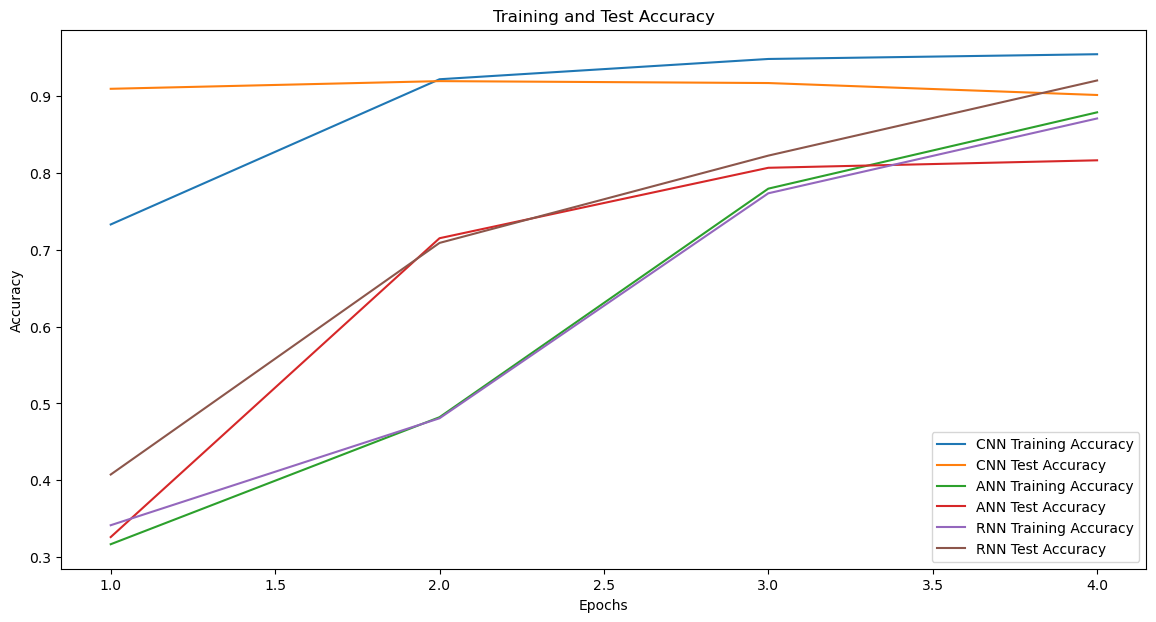

In [11]:
import matplotlib.pyplot as plt

# Get the minimum number of epochs so x,y have the same dimension
min_epochs = min(len(cnn_history.history['accuracy']), len(ann_history.history['accuracy']), len(rnn_history.history['accuracy']))

epochs = range(1, min_epochs + 1)

cnn_acc = cnn_history.history['accuracy'][:min_epochs]
cnn_val_acc = cnn_history.history['val_accuracy'][:min_epochs]
ann_acc = ann_history.history['accuracy'][:min_epochs]
ann_val_acc = ann_history.history['val_accuracy'][:min_epochs]
rnn_acc = rnn_history.history['accuracy'][:min_epochs]
rnn_val_acc = rnn_history.history['val_accuracy'][:min_epochs]

plt.figure(figsize=(14, 7))

plt.plot(epochs, cnn_acc, label='CNN Training Accuracy')
plt.plot(epochs, cnn_val_acc, label='CNN Test Accuracy')
plt.plot(epochs, ann_acc, label='ANN Training Accuracy')
plt.plot(epochs, ann_val_acc, label='ANN Test Accuracy')
plt.plot(epochs, rnn_acc, label='RNN Training Accuracy')
plt.plot(epochs, rnn_val_acc, label='RNN Test Accuracy')

plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


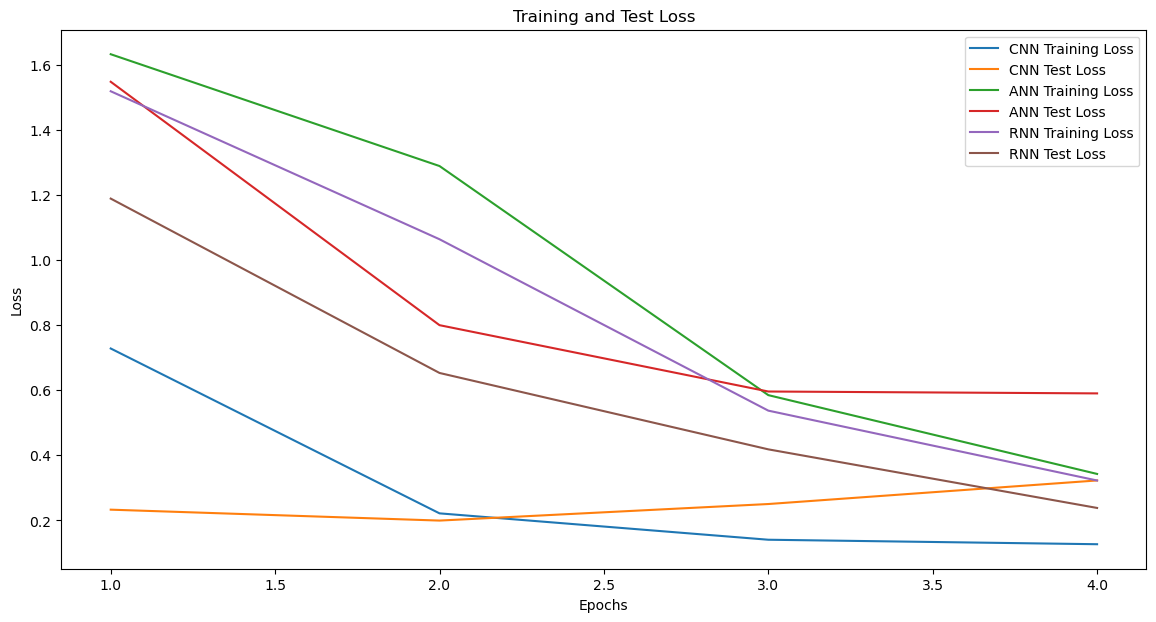

In [12]:
import matplotlib.pyplot as plt

# Get the minimum number of epochs so x,y have the same dimension
min_epochs = min(len(cnn_history.history['loss']), len(ann_history.history['loss']), len(rnn_history.history['loss']))

epochs = range(1, min_epochs + 1)

cnn_loss = cnn_history.history['loss'][:min_epochs]
cnn_val_loss = cnn_history.history['val_loss'][:min_epochs]
ann_loss = ann_history.history['loss'][:min_epochs]
ann_val_loss = ann_history.history['val_loss'][:min_epochs]
rnn_loss = rnn_history.history['loss'][:min_epochs]
rnn_val_loss = rnn_history.history['val_loss'][:min_epochs]

plt.figure(figsize=(14, 7))

plt.plot(epochs, cnn_loss, label='CNN Training Loss')
plt.plot(epochs, cnn_val_loss, label='CNN Test Loss')
plt.plot(epochs, ann_loss, label='ANN Training Loss')
plt.plot(epochs, ann_val_loss, label='ANN Test Loss')
plt.plot(epochs, rnn_loss, label='RNN Training Loss')
plt.plot(epochs, rnn_val_loss, label='RNN Test Loss')

plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()